In [33]:
%pip install --quiet fsrs==1.2.0

In [34]:
# Replace w with your optimized parameters
w = [0.5614, 1.2546, 3.5878, 7.9731, 5.1043, 1.1303, 0.823, 0.0465, 1.629, 0.135, 1.0045, 2.132, 0.0839, 0.3204, 1.3547, 0.219, 2.7849]
# Set this to the same value as the Starting Ease in your deck
starting_ease = 2.5
# Replace with your desired retention
request_retention = 0.90

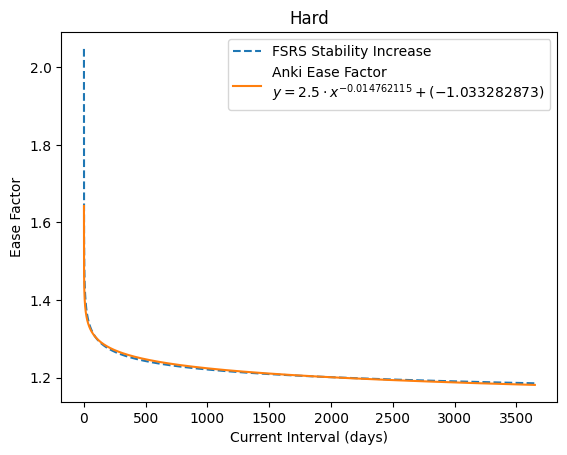


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.000023225
    Mean Absolute Error (MAE): 0.002705321
    Root Mean Squared Error (RMSE): 0.004819225
    


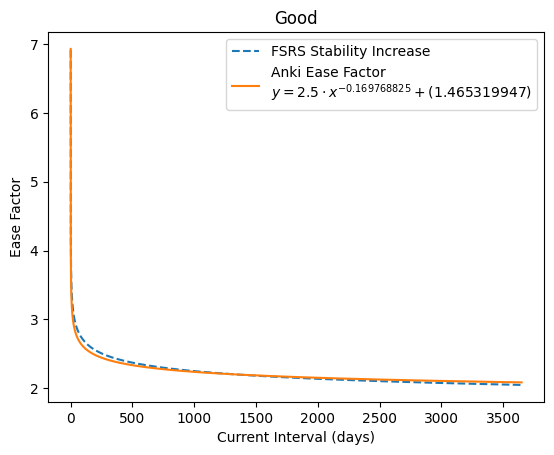


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.001331264
    Mean Absolute Error (MAE): 0.027194987
    Root Mean Squared Error (RMSE): 0.036486490
    


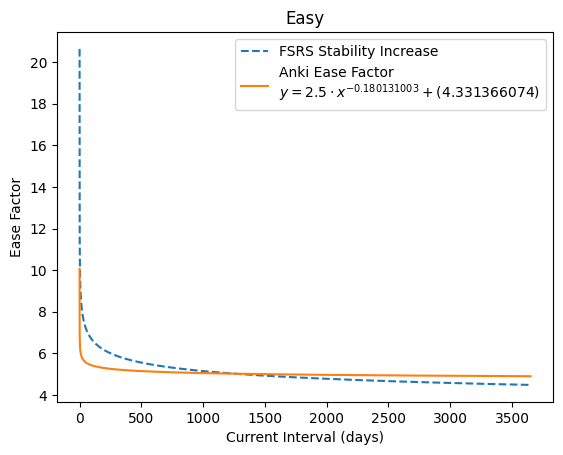


    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): 0.230665068
    Mean Absolute Error (MAE): 0.327897509
    Root Mean Squared Error (RMSE): 0.480276033
    

Replace your settings in the Deck Options for your deck with the values below.
Note:
1. Use `Graduating interval (good)` if you often press Good when first learning
   a new card
2. Otherwise, use `Graduating interval (hard)` if you often press Hard when
   first learning a new card
3. Otherwise, use `Graduating interval (again)` if you often press Again when
   first learning a new card
4. If you're not sure, use `Graduating interval (good)`
This is because FSRS considers the first rating for New cards when training its
parameters. Since Anki SM-2 does not consider the first rating for New cards, it
is best to set the Graduating interval to the one you most often use


Gradu

In [35]:
from datetime import datetime
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from typing import List

import copy
import fsrs
import matplotlib.pyplot as plt
import numpy as np


f = fsrs.FSRS()
f.p.request_retention = request_retention
f.p.maximum_interval = 1_000_000
f.p.w = w
card = fsrs.Card()
scheduling_cards = fsrs.models.SchedulingCards(card)
f.init_ds(scheduling_cards)


def fsrs_stability_increase(
    x_data: List[float],
    difficulty: float,
    retrievability: float,
    rating: fsrs.Rating
):
    return [
        f.next_recall_stability(difficulty, x, retrievability, rating) / x
        for x in x_data
    ]


def anki_ease_factor(x: List[float], a: float, b: float):
    return starting_ease * x ** a + b



x_data = np.linspace(0.01, 3650, 100000)



def fit_data(
    x_data: List[float],
    scheduling_cards: fsrs.models.SchedulingCards,
    rating: fsrs.Rating
):
    # Set retrievability to 0.90 because when converting to Anki SM-2, we need
    # to assume that the intervals have 90% retrievability
    if fsrs.Rating.Again == rating:
        difficulty = scheduling_cards.again.difficulty
    elif fsrs.Rating.Hard == rating:
        difficulty = scheduling_cards.hard.difficulty
    elif fsrs.Rating.Good == rating:
        difficulty = scheduling_cards.good.difficulty
    elif fsrs.Rating.Easy == rating:
        difficulty = scheduling_cards.easy.difficulty
    else:
        raise Exception(f"Unknown rating {rating}")
    y_data = fsrs_stability_increase(x_data, difficulty, 0.9, rating)
    params, _ = curve_fit(anki_ease_factor, x_data, y_data)

    y_approx = anki_ease_factor(x_data, *params)
    mse = mean_squared_error(y_data, y_approx)
    mae = mean_absolute_error(y_data, y_approx)
    rmse = np.sqrt(mse)

    return (params, y_data, y_approx, mse, mae, rmse)


hard_params, hard_y_data, hard_y_approx, hard_mse, hard_mae, hard_rmse = fit_data(x_data, scheduling_cards, fsrs.Rating.Hard)
good_params, good_y_data, good_y_approx, good_mse, good_mae, good_rmse = fit_data(x_data, scheduling_cards, fsrs.Rating.Good)
easy_params, easy_y_data, easy_y_approx, easy_mse, easy_mae, easy_rmse = fit_data(x_data, scheduling_cards, fsrs.Rating.Easy)


def plot_data(title: str, x_data: List[float], y_data: List[float], y_approx: List[float], params: List[float], mse: float, mae: float, rmse: float):
    plt.title(title)
    plt.plot(x_data, y_data, label="FSRS Stability Increase", linestyle="dashed")
    plt.plot(
        x_data,
        y_approx,
        label=f"Anki Ease Factor\n$y = {starting_ease} \\cdot x^{{{params[0]:.9f}}} + ({params[1]:.9f})$"
    )
    plt.legend()
    plt.xlabel("Current Interval (days)")
    plt.ylabel("Ease Factor")
    plt.show()

    print(f"""
    Lower error values is better. RMSE provides better insight in how well the
    Anki Ease Factor function fits to the FSRS Stability Increase function than
    MSE and MAE

    Mean Squared Error (MSE): {mse:.9f}
    Mean Absolute Error (MAE): {mae:.9f}
    Root Mean Squared Error (RMSE): {rmse:.9f}
    """)

plot_data("Hard", x_data, hard_y_data, hard_y_approx, hard_params, hard_mse, hard_mae, hard_rmse)
plot_data("Good", x_data, good_y_data, good_y_approx, good_params, good_mse, good_mae, good_rmse)
plot_data("Easy", x_data, easy_y_data, easy_y_approx, easy_params, easy_mse, easy_mae, easy_rmse)

copy_f = copy.deepcopy(f)
copy_f.p.maximum_interval = f.p.maximum_interval * 2
interval_modifier = copy_f.next_interval(f.p.maximum_interval) / f.p.maximum_interval

graduating_interval_again = scheduling_cards.again.stability * interval_modifier
graduating_interval_hard = scheduling_cards.hard.stability * interval_modifier
graduating_interval_good = scheduling_cards.good.stability * interval_modifier
easy_interval = scheduling_cards.easy.stability * interval_modifier
print(f"""
Replace your settings in the Deck Options for your deck with the values below.
Note:
1. Use `Graduating interval (good)` if you often press Good when first learning
   a new card
2. Otherwise, use `Graduating interval (hard)` if you often press Hard when
   first learning a new card
3. Otherwise, use `Graduating interval (again)` if you often press Again when
   first learning a new card
4. If you're not sure, use `Graduating interval (good)`
This is because FSRS considers the first rating for New cards when training its
parameters. Since Anki SM-2 does not consider the first rating for New cards, it
is best to set the Graduating interval to the one you most often use


Graduating interval (again): {graduating_interval_again:.0f}
Graduating interval (hard): {graduating_interval_hard:.0f}
Graduating interval (good): {graduating_interval_good:.0f}
Easy interval: {easy_interval:.0f}


Replace the scheduler settings for your deck in the Custom scheduling field in
the Deck Options with the following values:


scheduler: {{
    // ... (other settings)
    intervalModifier: {interval_modifier},
    calculateHardMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {hard_params[0]:.9f}) + ({hard_params[1]:.9f});
    }},
    calculateGoodMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {good_params[0]:.9f}) + ({good_params[1]:.9f});
    }},
    calculateEasyMultiplier: (currentEaseFactor, currentInterval) => {{
        return currentEaseFactor * Math.pow(currentInterval, {easy_params[0]:.9f}) + ({easy_params[1]:.9f});
    }},
}},

""")